In [1]:
import kagome, qiskit
import numpy as np
import matplotlib.pyplot as plt

startTime = kagome.strtime()
print(f"Start at {startTime}\n")
qVersion=kagome.init_notebook(output=True)

import qiskit.tools.jupyter
%qiskit_version_table

Start at Mon Feb 20 13:44:42 2023 UTC

qTools: myTools(major=1, minor=1, micro=0)
Qiskit: <dict>
    qiskit-terra : 0.22.4
    qiskit-aer : 0.11.2
    qiskit-ignis : 0.7.1
    qiskit-ibmq-provider : 0.19.2
    qiskit : 0.39.5
    qiskit-nature : 0.5.2
    qiskit-finance : 0.3.4
    qiskit-optimization : 0.4.0
    qiskit-machine-learning : None



In [2]:
# Setup Account, Provider, Service and Backends
from qiskit_ibm_runtime import (QiskitRuntimeService, Session, Options,
                                Estimator as RuntimeEstimator)

provider, service = kagome.get_provider(channel='ibm_quantum',
                                        hub='ibm-q', group='open', project='main',
                                        output=True,   # Print out the available backends
                                       )

from qiskit.providers.fake_provider import FakeGuadalupe
guadalupeFake    = FakeGuadalupe()
simulator        = provider.get_backend('simulator_statevector')
nairobi          = provider.get_backend('ibm_nairobi')
oslo             = provider.get_backend('ibm_oslo')

Available backends
	ibmq_qasm_simulator
	ibmq_quito
	simulator_stabilizer
	ibm_nairobi
	simulator_statevector
	ibmq_manila
	ibm_oslo
	ibmq_lima
	ibmq_belem
	simulator_extended_stabilizer
	simulator_mps


# Hamiltonians and Ansatze

In [3]:
# import statevector
import hamiltonians, ansatze
backends = {'7':nairobi,'16':FakeGuadalupe()}
#===================  Cell Structures ===================#
cells = hamiltonians.init_cells()
positions = hamiltonians.init_positions()

#====================  Hamiltonians =====================#
hams,eigenvalue_results,targets = hamiltonians.init_hamiltonians(cells=cells,force=False)
print("Hamiltonian Dimensions")
for key,value in hams.items():
    print(f"\t{key}:\t{value.primitive.dim}")
    
#=======================  Ansatze =======================#
Anzs = ansatze.init_ansatze(H=hams,backends=backends,targets=targets)
ansatze.list_Ansatz(Anzs)


H12_12: Edges 18 Eigenvalues 64 
	-18.0000:[2]
	-16.9613:[3]
	-16.9449:[6]
	-16.9296:[6]
	-16.8098:[3]
	-16.7353:[1]
	-16.7293:[2]
	-16.5674:[2]
	-16.3117:[3]
	-16.2754:[6]
	-16.2259:[1]
	-16.0412:[6]
	-15.6539:[3]
	-15.4601:[2]
	-15.3308:[3]
	-15.3178:[5]
	-15.1668:[10]

H12_16: Edges 18 Eigenvalues 64 
	-18.0000:[32]
	-16.9613:[25]
	-16.9449:[7]

H4_7: Edges 4 Eigenvalues 64 
	 -6.0000:[8]
	 -4.0000:[24]
	 -2.0000:[32]

H4_4: Edges 4 Eigenvalues 16 
	 -6.0000:[1]
	 -4.0000:[3]
	 -2.0000:[4]
	  2.0000:[3]
	  4.0000:[5]

H3_3: Edges 3 Eigenvalues 8 
	 -3.0000:[4]
	  3.0000:[4]

Hsq_4: Edges 4 Eigenvalues 16 
	 -8.0000:[1]
	 -4.0000:[3]
	 -0.0000:[7]
	  4.0000:[5]

Hsq_7: Edges 4 Eigenvalues 64 
	 -8.0000:[8]
	 -4.0000:[24]
	 -0.0000:[32]

H4_4_BC1: Edges 4 Eigenvalues 16 
	 -6.0000:[5]
	 -2.0000:[3]
	  2.0000:[3]
	  6.0000:[5]

H4_7_BC1: Edges 4 Eigenvalues 64 
	 -6.0000:[40]
	 -2.0000:[24]
Hamiltonian Dimensions
	12_12:	(4096, 4096)
	12_16:	(65536, 65536)
	4_7:	(128, 128)
	4_4:	(16, 

12_16
12_12
5_5
4_7
4_4
sq_4
sq_7
3_7
3_3
4_4_BC1
4_7_BC1


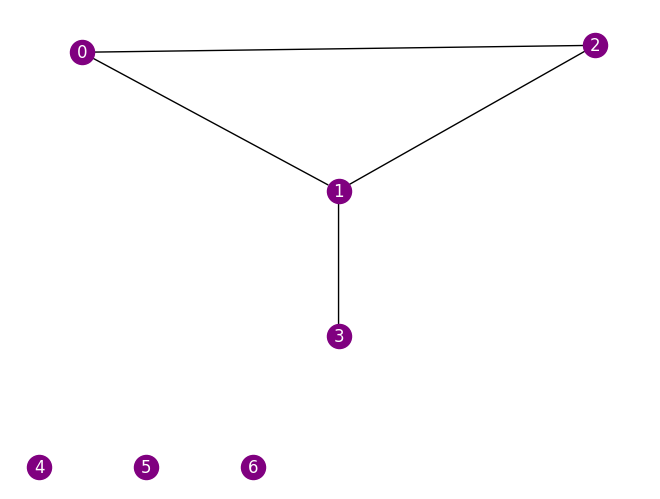

In [4]:
for key in cells:
    print(key)

_=kagome.draw_lattice(cells['4_7'],positions['4_7'])

# Optimizer Options

In [13]:
optimizers={}
from qiskit.algorithms.optimizers import SPSA
optimizers['00'] = {'opt': SPSA(maxiter=2), 'label':'SPSA(2)' }
optimizers['01'] = {'opt': SPSA(maxiter=75), 'label':'SPSA(75)' }
optimizers['02'] = {'opt': SPSA(maxiter=75,callback=kagome.SPSA_callback), 
                    'label':'SPSA(75,cb)' }
optimizers['03'] = {'opt': SPSA(maxiter=75,callback=kagome.SPSA_callback,blocking=True),
                    'label':'SPSA(75,cb,block)' }
optimizers['04'] = {'opt': SPSA(maxiter=150,callback=kagome.SPSA_callback),
                    'label':'SPSA(150,cb)' }
optimizers['05'] = {'opt': SPSA(maxiter=150,callback=kagome.SPSA_callback,blocking=True),
                    'label':'SPSA(150,cb,block)' }
optimizers['06'] = {'opt': SPSA(maxiter=300,callback=kagome.SPSA_callback),
                    'label':'SPSA(300,cb)' }
optimizers['07'] = {'opt': SPSA(maxiter=300,callback=kagome.SPSA_callback,blocking=True),
                    'label':'SPSA(300,cb,block)' }
optimizers['08'] = {'opt': SPSA(maxiter=150,callback=kagome.SPSA_callback,trust_region=True),
                    'label':'SPSA(150,cb,trust)' }
optimizers['09'] = {'opt': SPSA(maxiter=300,callback=kagome.SPSA_callback,trust_region=True),
                    'label':'SPSA(300,cb,trust)' }
optimizers['10'] = {'opt': SPSA(maxiter=300,callback=kagome.SPSA_callback,second_order=True),
                    'label':'SPSA(300,cb,O(2)' }
optimizers['11'] = {'opt': SPSA(maxiter=100,callback=kagome.SPSA_callback),
                    'label':'SPSA(100,cb)' }
optimizers['12'] = {'opt': SPSA(maxiter=100,callback=kagome.SPSA_callback,trust_region=True),
                    'label':'SPSA(100,cb,trust)' }
optimizers['13'] = {'opt': SPSA(maxiter=350,callback=kagome.SPSA_callback),
                    'label':'SPSA(350,cb)' }
optimizers['14'] = {'opt': SPSA(maxiter=200,callback=kagome.SPSA_callback),
                    'label':'SPSA(200,cb)' }

In [6]:
from qiskit_aer import AerSimulator, StatevectorSimulator

# from .aerbackend import AerBackend, AerError
max_parallel=3
nairobiSim   = AerSimulator(max_parallel_experiments=max_parallel).from_backend(nairobi)

svectorSim   = StatevectorSimulator(max_parallel_experiments=max_parallel)
nairobiSim   = AerSimulator(max_parallel_experiments=max_parallel).from_backend(nairobi)
osloSim      = AerSimulator(max_parallel_experiments=max_parallel).from_backend(oslo)
guadalupeSim = AerSimulator(max_parallel_experiments=max_parallel).from_backend(FakeGuadalupe())

from qiskit.primitives import BackendEstimator
backendNairobi = BackendEstimator(nairobiSim, skip_transpilation=False)

In [7]:
def runJob(Hkey=None,Akey=None,miniAkey=None,nshots=1024,optimization=3,resilience=1,
          pt_idx='Random',backend=None, Okey=None, numRuns=-1, service=None, x0=None, fname=None,
          job_tags=['runJob']):
    from qiskit_aer.backends.aerbackend import AerBackend, AerError
    if backend is None or isinstance(backend,AerBackend):
        service = None
        options = { 'shots': nshots }
    else:
        service = service
        options = Options(optimization_level = optimization, 
                          resilience_level  = resilience,
                          execution = {'shots':nshots}, 
                          environment = {'job_tags':job_tags},
                         )
#                           transpilation = {'skip_translation': False},        

    #==================== Job Control ======================
    label = (f"{backend}['shots':{nshots} 'Optimize':{optimization} 'Resilience':{resilience}]\n"
             f"H:{Hkey}A:{Anzs[Akey].name} \nOpt:{optimizers[Okey]['label']} x0={pt_idx}")
    if numRuns > 0:
        curCache = kagome.load_results(fname)
        for i in range(numRuns):
            print(f"Starting Run {i}")
            custom_vqe = kagome.run_kagomeVQE(hams[Hkey], Anzs[Akey], optimizers[Okey]['opt'], 
                                         miniAnsatz=Anzs[miniAkey],
                                         timeout=None, x0=x0, 
                                         target=np.around(targets[Hkey],6),
                                         service=service, backend=backend,
                                         resultsList=curCache, 
                                         label=label, options=options )
            kagome.save_results(curCache,fname)
        return curCache
    else:
        print(label)

In [38]:
#================= Problem Setup =====================
fname='H4_4_X1.dump'
curCache = kagome.load_results(fname)
#backends: 'simulator_statevector' svectorSim nairobiSim guadalupeSim
pt_idx = 'Random'        # '0'-> 0 vector; [int] -> point cache; else -> Random
x0 =  kagome.getX0(pt_idx,curCache)
runconfig = {'Hkey'         : '4_4',
             'fname'        : fname,
             'Akey'         : 'A4_SU2_X0',
             'miniAkey'     : 'A4_SU2_X0',
             'Okey'         : '13',         # 00->10 02->75 04->150 06->300 13->350 14->200
             'x0'           : x0,'pt_idx': pt_idx,
             'nshots'       : 1024,
             'optimization' : 3,
             'resilience'   : 1,
             'service'      : None,
             'backend'      : osloSim, 
             'numRuns'      : 1,
             'job_tags'     : ['H4_4','A4_S2_X2','Opt(3)','Res(1)','shots(1024)']
            }
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 177801   # For SPSA stochastic repeatability
curCache = runJob(**runconfig)

Loaded 6 results from H4_4_X1.dump
Loaded 6 results from H4_4_X1.dump
Starting Run 0
'aer_simulator(ibm_oslo)['shots':1024 'Optimize':3 'Resilience':1]
H:4_4A:|0000> A4_SU2_X0 
Opt:SPSA(350,cb) x0=Random idx=6
Runtime 4 min, 41 sec


Skipping iteration 148 with step=0.0
Skipping iteration 226 with step=0.0
Skipping iteration 259 with step=0.0
Skipping iteration 332 with step=0.0
Skipping iteration 334 with step=0.0
Convergence Failure
Duration 4 min, 41 sec Shots=None Iterations=350 Accepted=100.0 % Rejected=0 min at n=344
Expected -6.0 Ground State: Computed -5.080078 Min -5.142578 
Error 15.332031 % Minimum 14.290365 %


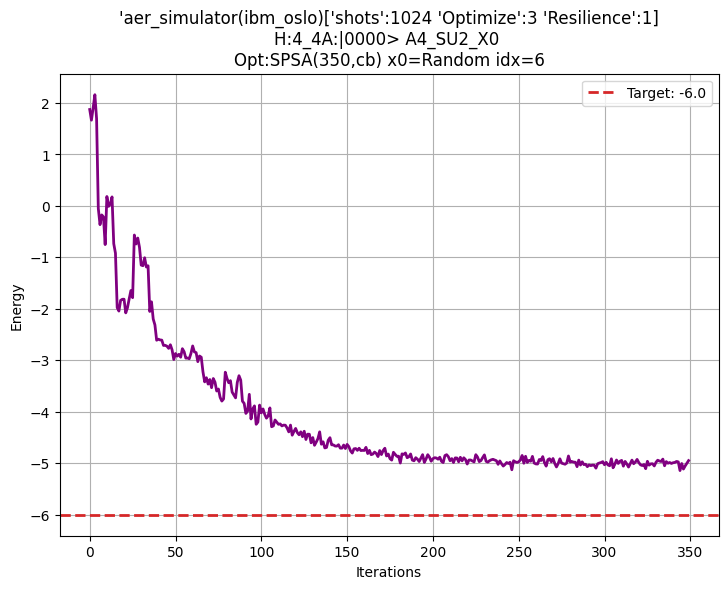

In [39]:
### idx 1:local(350) 2:aer_oslo(350))
idx_list = ['0']   # None -> 8
kagome.plot_SPSA_convergence(curCache,
                             indices=[-1],
                             conv_lim = 0.03,
                             movingAvg=5,
                             perc=6,
                             convergence=False,
                             minStart=20)

# Saves
### 3: Oslo 150 - Hsq_4

# Additional Python Code to Include

In [ ]:
# Options(optimization_level=0,
#         resilience_level=0,
#         max_execution_time=None,
#         transpilation=TranspilationOptions(skip_transpilation=False, 
#                                            initial_layout=None, 
#                                            layout_method=None, 
#                                            routing_method=None, 
#                                            approximation_degree=None), 
#         resilience=ResilienceOptions(noise_amplifier='TwoQubitAmplifier', 
#                                      noise_factors=(1, 3, 5), extrapolator='LinearExtrapolator'), 
#         execution=ExecutionOptions(shots=1000, init_qubits=True), 
#         environment=EnvironmentOptions(log_level='WARNING', callback=None, job_tags=[]), 
#         simulator=SimulatorOptions(noise_model=None, seed_simulator=None, coupling_map=None, basis_gates=None)
#        )

# options.optimization_level = 0 # No optimization
# options.optimization_level = 1 # Light optimization  (Default for transpile)
# options.optimization_level = 2 # Medium optimization
# options.optimization_level = 3 # Dynamical decoupling


# options.resilience_level = 0 # No error mitigation
# options.resilience_level = 1 # T-REx
# options.resilience_level = 2 # ZNE (Zero Noise Extraction)
# options.resilience_level = 3 # PEC (Probabilistic Error Correction)

In [ ]:
# idx = -1
# curResult = curCache[idx]

# plot_bloch_multivector(VQE2MiniSvector(curResult))
# displayNormedData(curResult,nqubits=4)

# Svector_normed,_= getNormedState(curResult)
# coords=getCoords(Svector_normed)
# for q_coords in coords:
#     print(np.real(q_coords))

In [ ]:
curCache = kagome.load_results(fname)
kagome.list_results(curCache,reverse=True)

In [26]:
import importlib
import jTools
importlib.reload(hamiltonians)
importlib.reload(ansatze)
importlib.reload(kagome)
jTools.cellOutputAll()

# Boundary Conditions

## Sub-lattice
### Consider the lattice consisting of Nodes 0, 1, 2, and 3

* The full lattice can be built three (3) copies of this sub-lattice
* Nodes 0, 4, and 7, the starting corners of each sub-lattice
* Impose boundary conditions between 0 <-> 4 <-> 7 <-> 0
* Solve the energy level of the sub-lattice 0 thru 4 (5 nodes)
   * Use 4 nodes (0-3)
   * Boundary conditions to map H entries from 1<->4 and 3<->4

Node 4 is  related to Node 0 such that

$$
    \psi_4  =K*\psi_0  \\
    K^3 = I
$$

Assuming symetric rotations around the lattice we have

$$  
   K_i =R_x(\theta_i)*R_y(\phi_i)*R_z(\lambda_i) \\ i\in [0,1,2]  \\
   \sum_{i=0}^2\theta_i = n*2\pi \quad n \in I \\
   \sum_{i=0}^2\phi_i = n*2\pi  \\
   \sum_{i=0}^2\lambda_i = n*2\pi  \\
$$
 
Simple starting points are

$$  
\begin{equation}
(1) \quad \theta_i = \phi_i = \lambda_i = 0  \\
(2) \quad \theta_i = \phi_i = \lambda_i = \frac{2\pi}{3}  \\
(3) \quad \theta_i = \phi_i = \lambda_i = \frac{4\pi}{3}  \label{eq1} \\
\end{equation}
$$

For case 1:
$$
K=I  \\
\psi_4 = \psi_0
$$

# Adding Boundary Conditions
## Add Hamiltonian entries on the boundary
Must add $XX + YY + ZZ$ on virtual edges of the sub-lattice for to Node 4
$$\psi_1 \psi_4 = \psi_1\psi_0 + \psi_1 (K*\psi_0) \\
\psi_3 \psi_4 = \psi_3 (K\psi_0) $$
For case 1, $K=I$ the additional Hamiltonian entries are:

\begin{align}
H_{case1} =~~ &1.0*(IIZZ+IIYY+IIXX)~~ + \\ &1.0*(ZIIZ+YIIY+XIIX) 
\end{align}
